In [1]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='white', context='notebook', palette='deep')
pylab.rcParams['figure.figsize'] = 12,8
mpl.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

df_train = pd.read_csv('raw/train.csv')

In [2]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

def encode_features(df_train):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = df_train[features]
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
    return df_train

df_train = transform_features(df_train)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [3]:
df_train = encode_features(df_train)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,73,17
1,2,1,1,0,0,1,0,3,2,136,18
2,3,1,3,0,7,0,0,0,7,251,14
3,4,1,1,0,7,1,0,3,2,198,18
4,5,0,3,1,7,0,0,1,7,11,17


In [4]:
x_all = df_train.drop(['PassengerId', 'Survived'], axis=1)
y_all = df_train['Survived']

num_test = 0.3
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=num_test, random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_score = accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7574626865671642


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#We need to reshape our data since the Scaler takes in arrays
ages_train = np.array(df_train["Age"]).reshape(-1, 1)
fares_train = np.array(df_train["Fare"]).reshape(-1, 1)

df_train["Age"] = scaler.fit_transform(ages_train)
df_train["Fare"] = scaler.fit_transform(fares_train)

In [6]:
x_all = df_train.drop(['PassengerId', 'Survived'], axis=1)
y_all = df_train['Survived']

num_test = 0.3
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=num_test, random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_score = accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7723880597014925


In [7]:
df_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,-0.011933,1,0,-1.315798,7,73,17
1,2,1,1,0,-1.530855,1,0,1.260853,2,136,18
2,3,1,3,0,1.127258,0,0,-1.315798,7,251,14
3,4,1,1,0,1.127258,1,0,1.260853,2,198,18
4,5,0,3,1,1.127258,0,0,-0.456915,7,11,17


In [8]:
logreg_clf = LogisticRegression()

parameters_logreg = {"fit_intercept": [True, False],
                     "max_iter": [10, 50, 100, 200, 500, 1000], 
                     "warm_start": [True, False]}

grid_logreg = GridSearchCV(logreg_clf, parameters_logreg, scoring=make_scorer(accuracy_score))
grid_logreg.fit(X_train, y_train)

logreg_clf = grid_logreg.best_estimator_

logreg_clf.fit(X_train, y_train)

logreg_prediction = logreg_clf.predict(X_test)
logreg_score = accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7611940298507462


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten , Dense, Activation, Dropout

def create_model(dropout_rate=0.0, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_shape=(9, )))
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(
        loss='binary_crossentropy',  
        optimizer=optimizer, 
        metrics=['accuracy']  # report accuracy during training
    )
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(
    build_fn=create_model,
    epochs=20, batch_size=10, verbose=0)


# define the grid search parameters
# batch_size = [16, 32, 64, 128]
epochs = [50, 100, 200]
# dropout_rate = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# activation = ['relu', 'tanh', 'sigmoid']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

dropout_rate = [0.2, 0.1]
param_grid = dict(
                  dropout_rate=dropout_rate)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    verbose=2,
                    cv=5,
                    )

grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] dropout_rate=0.2 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. dropout_rate=0.2, total=   2.5s
[CV] dropout_rate=0.2 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] ................................. dropout_rate=0.2, total=   1.9s
[CV] dropout_rate=0.2 ................................................
[CV] ................................. dropout_rate=0.2, total=   2.2s
[CV] dropout_rate=0.2 ................................................
[CV] ................................. dropout_rate=0.2, total=   2.3s
[CV] dropout_rate=0.2 ................................................
[CV] ................................. dropout_rate=0.2, total=   2.7s
[CV] dropout_rate=0.1 ................................................
[CV] ................................. dropout_rate=0.1, total=   1.9s
[CV] dropout_rate=0.1 ................................................
[CV] ................................. dropout_rate=0.1, total=   2.0s
[CV] dropout_rate=0.1 ................................................
[CV] ................................. dropout_rate=0.1, total=   2.3s
[CV] dropout_rate=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Best: 0.686968 using {'dropout_rate': 0.1}
0.685484 (0.034140) with: {'dropout_rate': 0.2}
0.686968 (0.039229) with: {'dropout_rate': 0.1}


In [12]:
grid_best = grid.best_estimator_

history = grid_best.fit(X_train, y_train)

logreg_prediction = grid_best.predict(X_test)
logreg_score = accuracy_score(y_test, logreg_prediction)
print(logreg_score)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.6268656716417911


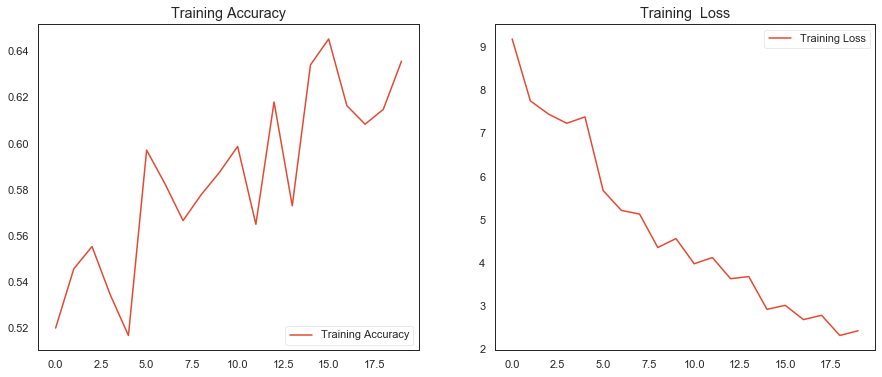

In [16]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(20)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')

plt.show()